# Data Mining / Prospecção de Dados 2022/2023

## André Falcão e Sara C. Madeira, 2019 - 2023


## Lab class TP08 

## Summary
1. The DBSCAN method for clustering
2. Using OPTICS from scikit-learn
3. Methods for evaluating clustering approaches
    1. Without ground truth
    2. With ground truth



## 1 Density-based spatial clustering of applications with noise (DBSCAN) 

### 1.1. Initialization

Here we will initialize everything. The environment and required libraries



In [3]:
%matplotlib inline  
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

Now let's initialize our old 10 points dataset and, because we will need it later, the old faithful iris dataset.

In [4]:
x=[1.3,3.5,2.0,5.0,6.0,4.9,7.7,3.0,8.0,2.9]
y=[3.2,6.7,4.0,6.3,7.0,1.4,1.0,3.2,8.1,2.0]

dat=np.array([x,y]).transpose()


from sklearn.datasets import load_iris
iris = load_iris()['data']

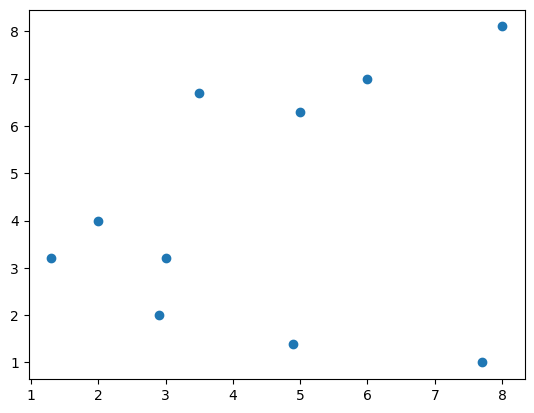

In [5]:
plt.scatter(x,y)

### 1.2. Basis of the DBSCAN algorithm


DBSCAN uses the concept of a **core point**, which is a point with a number of neighbours (including itself) larger than a given number. So to define a core point we will require 2 parameters:
1. a maximum distance required so that any point is considered a neighbour (`eps`)
2. a minimum mumber of neighbours required so that the point is considered a core point `Nmin`)


The main idea is the following

1. Identify the core points
2. Make the clusters as the **connected components** of core points on the neighborhood graph 
3. Assign each non-core point to the core-point connected cluster if the distance to each vertex is smaller than `eps`, otherwise set it to noise



**Running our sample case**

For commodity let's compute the distance matrix, although it is not strictly necessary. 

We will also compute the average distance as it can be a first approximation for computing the Eps parameter.

We will assume an Euclidean distance for the following explanation, but numpy has plenty options to choose from](  https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

In [6]:
D=pdist(dat, metric='euclidean')

dists=squareform(D, checks=True)

for d in dists[:5]:
    print(d[:5])
    
mean_D=sum(D)/len(D)
print("\nAverage distance: ", mean_D )

[0.         4.13400532 1.06301458 4.82700735 6.04400529]
[4.13400532 0.         3.08868904 1.55241747 2.51793566]
[1.06301458 3.08868904 0.         3.78021163 5.        ]
[4.82700735 1.55241747 3.78021163 0.         1.22065556]
[6.04400529 2.51793566 5.         1.22065556 0.        ]

Average distance:  4.415332127471144


**Connectedness of the full dataset**

For that let's define the neighbours and assume a minimum distance $eps=\frac{mean(D)}{2}$, and an $Nmin=3$ 

The procedure below uses the distance matrix for computing the core points and highlights each core point with a *.

In [7]:
eps= mean_D/2
Nmin=3

print("Neighbours list:")
i=0
neighbs=[]
for dst_a in dists:
    s=set([j for j in range(len(dst_a)) if dst_a[j] < eps])
    neighbs.append(s)
    if len(s)>=Nmin: print("\t*",i, "--->",  s) 
    else: print("\t ",i, "--->",  s) 
    i+=1

Neighbours list:
	* 0 ---> {0, 9, 2, 7}
	  1 ---> {1, 3}
	* 2 ---> {0, 9, 2, 7}
	* 3 ---> {1, 3, 4}
	  4 ---> {3, 4}
	  5 ---> {9, 5}
	  6 ---> {6}
	* 7 ---> {0, 9, 2, 7}
	  8 ---> {8}
	* 9 ---> {0, 2, 5, 7, 9}


For this case, the core points are thus [0,2,3,7,9]

Again, the DBSCAN algorithm can be briefly described like this:

1. Find the core points that are connnected, meaning that they share at least one point. These will be the clusters
2. Assign each non-core point to a neighboring cluster if it exists or to NOISE

The full procedure then just goes across the database and takes advantage of the graph structure inducted by the core points neighborhoods by adding its neighbors to each cluster iteratively as they are being discovered.

In the following function, each point starts as **undefined** [code=-1] (unvisited). As the procedure continues, a point is assigned to a cluster [code > 0] or noise [code=0].


**QUESTIONS:** 
* Is it possible that a non-core point belongs to more than one cluster?
    - Yes
* Can the order of the points in the data frame produce different clusering outcomes?
    - No

In [8]:
neighbs

[{0, 2, 7, 9},
 {1, 3},
 {0, 2, 7, 9},
 {1, 3, 4},
 {3, 4},
 {5, 9},
 {6},
 {0, 2, 7, 9},
 {8},
 {0, 2, 5, 7, 9}]

In [9]:
def dbscan_runner(neighbs, eps, Nmin): 
    UNDEF = -1
    NOISE =  0
    N=len(neighbs)

    ccount=0 #cluster counter    
    clusts=[UNDEF]*N 
    for p in range(N):
        if clusts[p] == UNDEF:
            ns=neighbs[p]
            if len(ns)<Nmin:
                clusts[p] = NOISE
            else:
                ccount+=1
                clusts[p]=ccount
                #this is our expansion set - starting with the neighbours of the first core point
                exp_set= list(ns - {p})
                Npp=0
                while Npp<len(exp_set):
                    cand_p=exp_set[Npp]
                    if clusts[cand_p] == NOISE: clusts[cand_p]=ccount
                    if clusts[cand_p] == UNDEF:
                        clusts[cand_p]=ccount
                        ns=neighbs[cand_p]
                        #print(p, cand_p, clusts[cand_p],exp_set, ns)
                        #and here is the critical bit. If the next point is a core point then we will add its neighbours 
                        # to the expansion set
                        if len(ns)>=Nmin: exp_set+=list(ns - set(exp_set) )
                    Npp+=1
    return clusts

We can now run DBSCAN on our dataset by calling the function directly and we can observe 2 clusters and 2 points as noise


The DBSCAN clustering produced the following assignments:  [1, 2, 1, 2, 2, 1, 0, 1, 0, 1]
1 [0, 2, 5, 7, 9]
2 [1, 3, 4]
0 [6, 8]


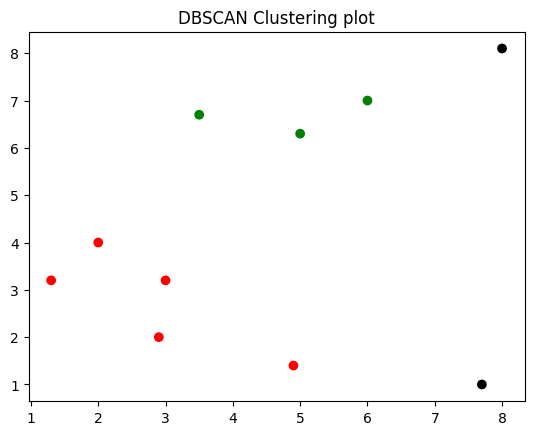

In [10]:
eps= mean_D/2
Nmin=3

cls=dbscan_runner(neighbs, eps, Nmin)

print("The DBSCAN clustering produced the following assignments: ",cls)
clusters={}
for i,c in enumerate(cls): clusters.setdefault(c,[]).append(i)

for c in clusters:
    print(c, clusters[c])

#this will not work well if more than 2 clusters are produced
color_assigs=list(np.array(["k", "r", "g"])[cls]) 
plt.scatter(x, y,c=color_assigs)
plt.title('DBSCAN Clustering plot')
#plt.legend()
plt.show()

### 1.3 Putting it all together

Now that we have the building blocks of the algorithm, we can make a DBSCAN function that accepts as input:
    
1. A numpy array with the existing data
2. a maximum distance (eps) for deighborhoud
3. a minimum number of elements for considering any instance a core point

The Euclidean distance is default but it is possible to choose any of the ones made available by numpy.

In [11]:
def myDBSCAN(dat, eps, Nmin, dtype="euclidean"):
    #first compute the distance matrix
    D=pdist(dat, metric=dtype)
    dists=squareform(D, checks=True)
    #then get the core points
    neighbs=[]
    for dst_a in dists:
        s=set([j for j in range(len(dst_a)) if dst_a[j] < eps])
        neighbs.append(s)
    #finally run the DBSCAN procedure with the 
    cls=dbscan_runner(neighbs, eps, Nmin)
    return cls

We can now change any of the parameters and verify what happens.

Cluster: 1 --> [0, 2, 7, 9]
Cluster: 2 --> [1, 3, 4]
Cluster: 0 --> [5, 6, 8]


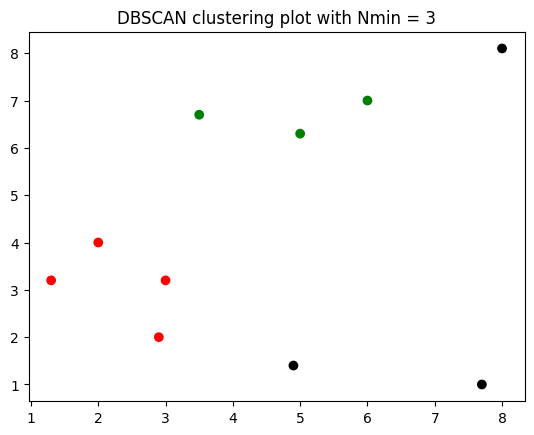

In [12]:
eps=1.8
Nmin=3

cls=myDBSCAN(dat,eps, Nmin)
clusters={}
for i,c in enumerate(cls): clusters.setdefault(c,[]).append(i)
for c in clusters:
    print("Cluster:", c, "-->", clusters[c])

color_assigs=list(np.array(["k", "r", "g"])[cls]) 
plt.scatter(x, y,c=color_assigs)
plt.title('DBSCAN clustering plot with Nmin = '+str(Nmin))
plt.show()



### 1.4.  The Quest for the Iris

Or we can try DBSCAN os the iris dataset:

In [13]:
from sklearn.datasets import load_iris
iris = load_iris().data

Number of instances in cluster 1: 47
Number of instances in cluster 2: 38
Number of instances in cluster 4: 4
Number of instances in cluster 3: 36
Number of NOISE instances: 25


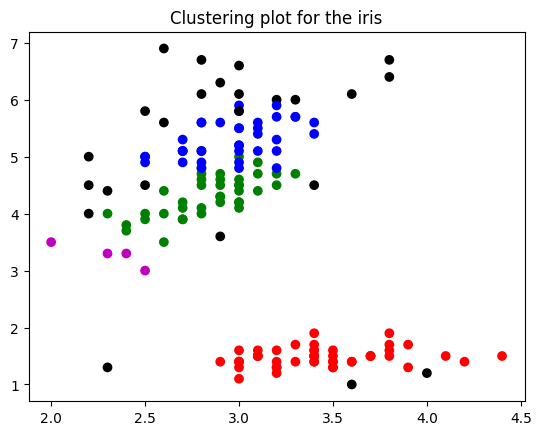

In [14]:
eps=.4
Nmin=4

cls=myDBSCAN(iris,eps, Nmin)
clusters={}
for i,c in enumerate(cls): clusters.setdefault(c,[]).append(i)
for c in clusters:
    if c!=0:  
        print("Number of instances in cluster %d: %d" %(c,len(clusters[c])))
print("Number of NOISE instances: %d" %(len(clusters[0])))
        
color_assigs=list(np.array(["k", "r", "g", "b", "m"])[cls]) 
plt.scatter(iris[:,1], iris[:,2], c=color_assigs)
plt.title('Clustering plot for the iris')
plt.show()

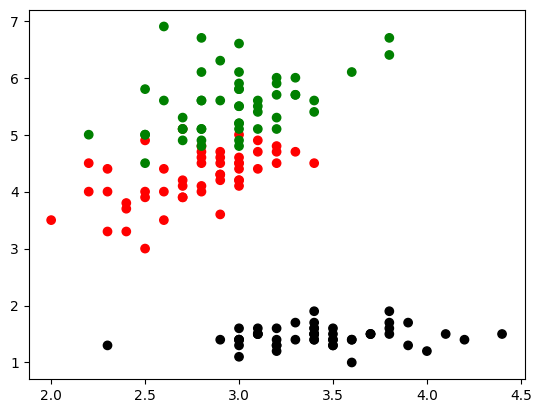

In [15]:
color_assigs=list(np.array(["k", "r", "g", "b", "m"])[load_iris()["target"]]) 
plt.scatter(iris[:,1], iris[:, 2], c=color_assigs)

### 1.5. DBSCAN in Scikit-Learn

DBSCAN is implemented as usual in Scikit-Learn.

Note that Scikit's implementation gives clusters starting at zero and not at one as the DBSCAN code above so we will add 1 to plot and print the same results. NOISE is -1

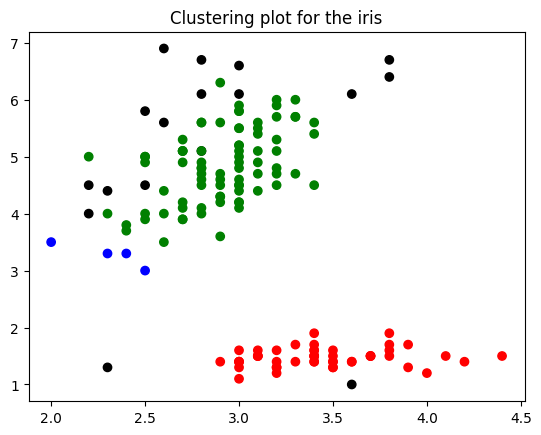

In [16]:
from sklearn.cluster import DBSCAN

eps  = 0.44
Nmin = 4
db = DBSCAN(eps=eps, min_samples=Nmin).fit(iris)
cls = 1+db.labels_

color_assigs=list(np.array(["k", "r", "g", "b", "m"])[cls]) 
plt.scatter(iris[:,1], iris[:,2], c=color_assigs)
plt.title('Clustering plot for the iris')
plt.show()


In [17]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

### 1.5. Discussion points

1. Apparently DBSCAN does not require to know K beforehand, why is that?
    - Density clustering method
2. What is the complexity of DBSCAN? is it appropriate for clustering very large amounts of data?
    - $O(N^2)$ ?
3. Is DBSCAN stable? (will it produce ALWAYS the same clustering?)
    - Yes
4. What is the main issue with DBSCAN? Discuss strategies to mitigate it
    - Parameter optimizations?
5. Compare k-means, HAC and DBSCAN in their strengths and weaknesses 


## 1.6 A new data set

We are going to use all the known methods with the diabetes dataset

In [18]:
from sklearn.datasets import load_diabetes
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#may be important in some installations in Windows
import os
os.environ["OMP_NUM_THREADS"]="5"

dia=load_diabetes()
X, y = dia.data, dia.target
dia_df = pd.DataFrame(X, columns=dia.feature_names)
dia_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


#### Exercises

1. How would you find good parameters for this dataset if using DBSCAN?
2. Discuss your findings


In [19]:
for ep in np.linspace(0.1, 1.5, 10):
    for m in range(2,5):
        db = DBSCAN(ep, min_samples=m).fit(dia_df)
        print(np.unique(db.labels_))

[-1  0  1  2  3  4]
[-1  0  1]
[-1  0  1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


## The OPTICS Clustering method from scikit learn

It would not be difficult to implement OPTICS from its basic premises, however, scikit-learn has a robust implementation that encompasses several improvements to the basic algorithm as weel as the possibiltu of working from sparse data matrices, faster neighbour computation and the possiblitiy of parallele processing

The code below is an adaptation from an [original approach by Shane Grigsby and Adrin Jalali](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py) 

First let's load a synthetic 2D dataset and plot it


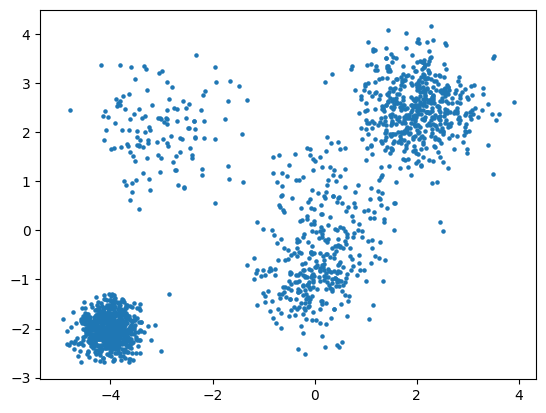

In [20]:
import pickle
data = pickle.load(open("5centers.pickle", "rb"))

plt.scatter(data[:,0], data[:,1], s=5)
plt.show()


Now let's run OPTICS from scikit-learn directly using some simple parameters. This will produce a simple clustering of the data set that can be visualised easily

UNDEFINED points: 550
Cluster 0 --> 131
Cluster 1 --> 339
Cluster 2 --> 700


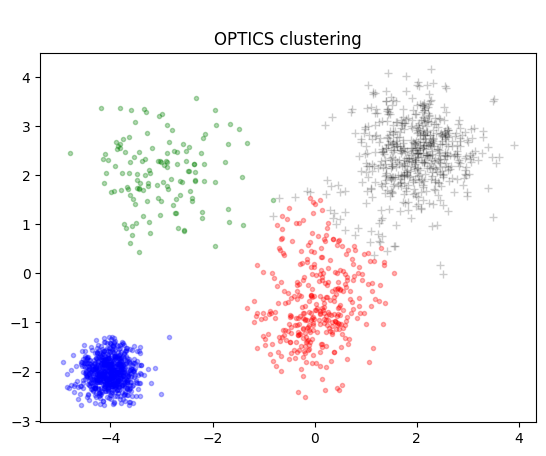

In [21]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

clust = OPTICS(min_samples=50, min_cluster_size=0.05)
clust.fit(data)

labels, counts=np.unique(clust.labels_[clust.ordering_], return_counts=True)
for i, L in enumerate(labels):
    if L==-1: print("UNDEFINED points:", counts[i])
    else: print("Cluster", L, "-->", counts[i])
    
colors = ["g.", "r.", "b.", "y.", "c."]
for k, color in zip(range(0, 5), colors):
    Xk = data[clust.labels_ == k]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(data[clust.labels_ == -1, 0], data[clust.labels_ == -1, 1], "k+", alpha=0.2)
plt.title("\nOPTICS clustering")
plt.show()

We ca take a closer look at what is going on by looking into the reachability plot, which will plot all points according to its neighbours and how close it is to reach it

It is actually visible in black a full set of points that were unassigned

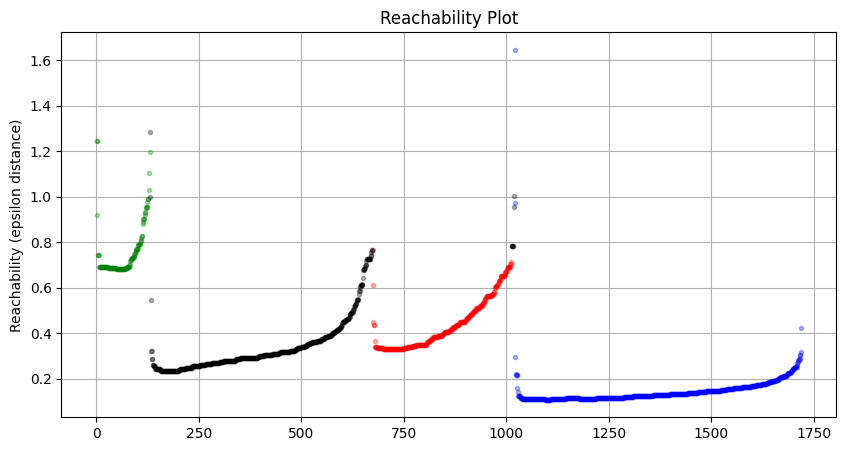

In [22]:
space = np.arange(len(data))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10,5))
colors = ["g.", "r.", "b.", "y.", "c."]
for k, color in zip(range(0, 5), colors):
    Xk = space[labels == k]
    Rk = reachability[labels == k]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3) #<--- the UNASSIGNED POINTS
plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")
plt.grid()
plt.show()

Using the reachability plot we can use DBSCAN to refine the OPTICS clustering, by selecting an adequate Epsilon (`eps`) threshold

The scikit-`learn cluster_optics_dbscan` function receives the required data from the OPTICS clustering(reaachability data, core distances and respective data ordering) plus a user defined value to automatically define a new clustering frtom the same dataset

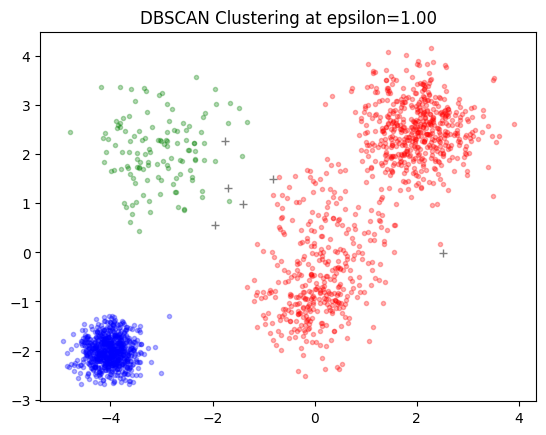

In [23]:

eps=1
dbs_labels = cluster_optics_dbscan(reachability=clust.reachability_,core_distances=clust.core_distances_, ordering=clust.ordering_, eps=eps)

colors = ["g.", "r.", "b.", "c."]
for k, color in zip(range(0, 4), colors):
    Xk = data[dbs_labels == k]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(data[dbs_labels == -1, 0], data[dbs_labels == -1, 1], "k+", alpha=0.5)
plt.title("DBSCAN Clustering at epsilon=%4.2f"% eps)
plt.show()

#### Exercises
1. investigate a better `eps` threshold for a better clustering [HINT: look at the reachability plot]


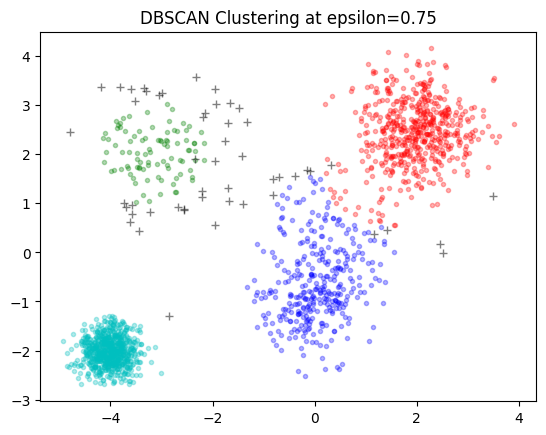

In [24]:
# Exercise 1

eps=0.75
dbs_labels = cluster_optics_dbscan(reachability=clust.reachability_,core_distances=clust.core_distances_, ordering=clust.ordering_, eps=eps)

colors = ["g.", "r.", "b.", "c."]
for k, color in zip(range(0, 4), colors):
    Xk = data[dbs_labels == k]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(data[dbs_labels == -1, 0], data[dbs_labels == -1, 1], "k+", alpha=0.5)
plt.title("DBSCAN Clustering at epsilon=%4.2f"% eps)
plt.show()



## 3. How to evaluate clusters

There are several metrics for evaluating the quality of clusters. They can be roughly divided as "unsupervised" e "supervised"
 * **Unsupervised** - The cluster quality is evaluated on its merits alone , meaning how well clusters are separated
 * **Supervised** - We have some prior knowledge and we are going to check how coherent is our clustering, and whether or not the elements in each known group are coherently distributed ber cluster

Although most of them would be trivial to compute, we are going to use the built-in library of scores in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)


### 3.1 Unsupervised metrics

#### 3.1.1. The Elbow Method 
The simplest score might just be the average of the overall distance within clusters: The intracluster distance 

If we have one cluster, then we will have the average distance between all instances. On the other hand if there are N clusters, the average distance intracluster will be zero. We should look for a number of clusters before the reduction of the intracluster distance becomes too small (the "elbow"

First create a function that computes the intracluster distances, and then test it with different Ks

In [25]:
import warnings
warnings.filterwarnings("ignore")

def avgDist(X, labels):
    D=pdist(X, metric='euclidean')
    dmatrix=squareform(D, checks=True)
    N=len(labels)
    L=list(set(labels))
    L.sort()
    result=0
    for i in L:
        Nc=sum(labels==i)
        S=0
        if Nc>1: S=np.sum(dmatrix[labels==i,:][:,labels==i])/(Nc*(Nc-1))
        result+=S*Nc/N
    return result



ads=[]
KS=[2<<i for i in range(0, int(np.log2(442)))]
for K in KS:
    kms = KMeans(n_clusters=K).fit(X)
    ad=avgDist(X, kms.labels_)
    print("%3d --> %7.4f"% (K, ad))
    ads.append(ad)
    


  2 -->  0.1744
  4 -->  0.1595
  8 -->  0.1425
 16 -->  0.1283
 32 -->  0.1144
 64 -->  0.1001
128 -->  0.0785
256 -->  0.0429


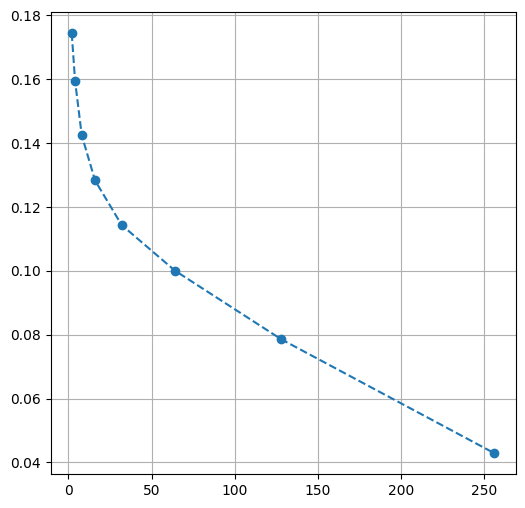

In [26]:
plt.figure(figsize=(6,6))
plt.plot(KS, ads, "--o")
plt.grid()
plt.show()


#### 2.1.2. Silhouette score

The [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) aims at identifying how each item is more aptly classified in its own cluster as compared to all the other possible clusters. Therefore a score is computed that ranges from -1 to +1. The higher the value, the more appropriate that item has been attributed to that cluster

Also we can compute an aggregated score (the *silhouette score*) as the average of all clustered attributions

In [27]:
from sklearn.metrics.cluster import silhouette_score, silhouette_samples

K=5
eps=.1
Nmin=9
kms = KMeans(n_clusters=K, random_state=0).fit(X)
dbs = DBSCAN(eps=eps, min_samples=Nmin).fit(X)
hac = AgglomerativeClustering(linkage="complete", n_clusters=K).fit(X)

print("Kmeans silhouette_score", silhouette_score(X, kms.labels_))
print("   HAC silhouette_score", silhouette_score(X, hac.labels_))
print("DBSCAN silhouette_score", silhouette_score(X, dbs.labels_+1))


Kmeans silhouette_score 0.14702497373194579
   HAC silhouette_score 0.0608597405734773
DBSCAN silhouette_score 0.12306603535069563


**Discuss** Discuss these results and especially pay attention to the DBSCAN result


Let's do the same analysis for the silhouette score as we have done for the average cluster distance for KMeans

In [28]:
ads=[]
KS=[2,4,8,16,32, 64, 128, 256]
for K in KS:
    kms = KMeans(n_clusters=K).fit(X)
    ss=silhouette_score(X, kms.labels_)
    print("%3d --> %7.4f"% (K, ss))
    ads.append(ad)

  2 -->  0.2370
  4 -->  0.1386
  8 -->  0.1420
 16 -->  0.1368
 32 -->  0.1237
 64 -->  0.1288
128 -->  0.1374
256 -->  0.1189



To visualize the individual sillhouetes let's use a nifty little function 

In [29]:
import matplotlib.cm as cm
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()


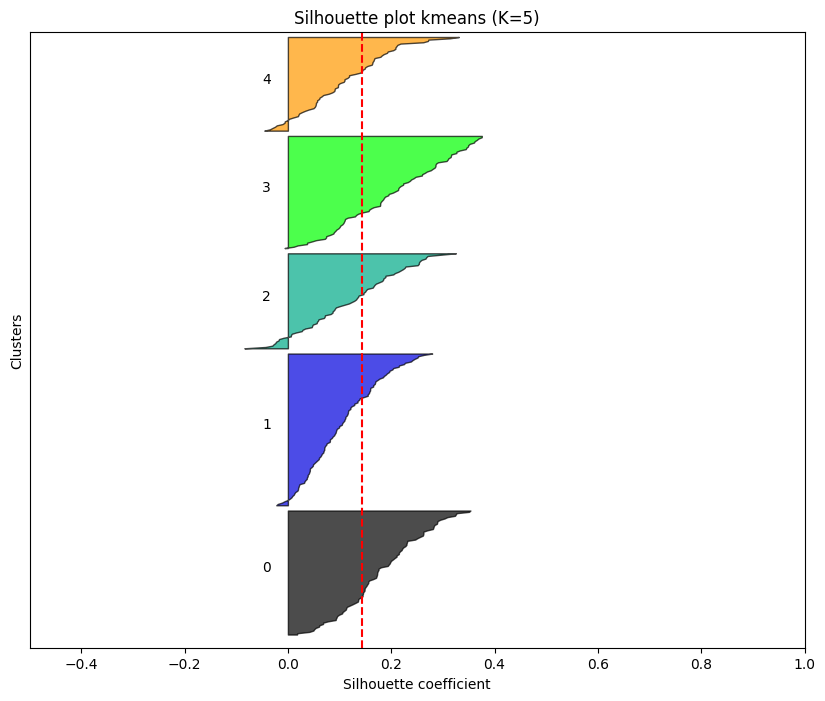

In [30]:

kms = KMeans(n_clusters=5).fit(X)
drawSillouette(X, kms.labels_, "kmeans (K=5)")

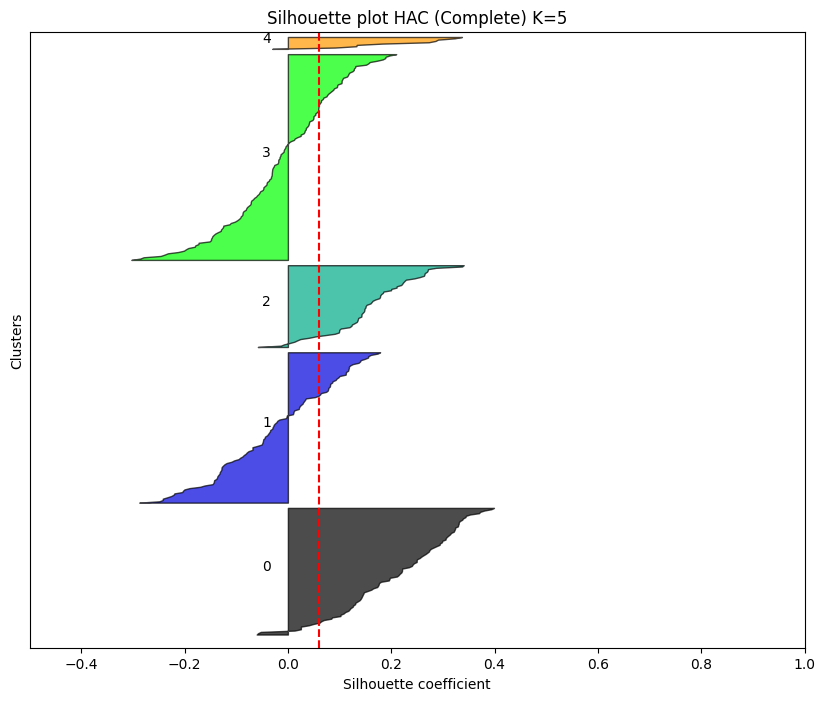

In [31]:
drawSillouette(X, hac.labels_, "HAC (Complete) K=5")

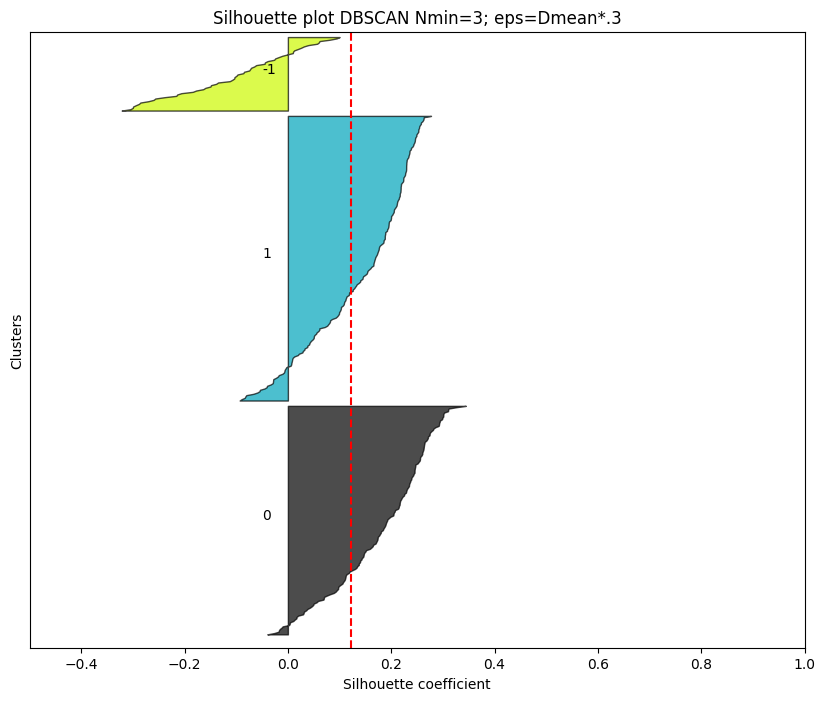

In [32]:
drawSillouette(X, dbs.labels_, "DBSCAN Nmin=3; eps=Dmean*.3")

**Exercise** Analize these plots and discuss them.
1. How good does the average score is for assessing clustering quality?
2. what type of information can you retrieve from the plots?
3. wow could you improve your analysis and results?


#### 2.1.2. The Calinsky-Harabasz metric

[The Calinsky-Harabasz metric](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index) or variance ratio criterion measures the importance of within-cluster dispersion versus between-cluster dispersion

It is not finitely scaled but higher values indicate more tight clusters as the distances between instances and their cluster assignments is smaller than the inter cluster centroids


In [33]:
from sklearn.metrics.cluster import calinski_harabasz_score

print("Kmeans Calinski Harabasz score", calinski_harabasz_score(X, kms.labels_))
print("   HAC Calinski Harabasz score", calinski_harabasz_score(X, hac.labels_))
print("DBSCAN Calinski Harabasz score", calinski_harabasz_score(X, dbs.labels_))


Kmeans Calinski Harabasz score 87.48293199474587
   HAC Calinski Harabasz score 51.39503967872988
DBSCAN Calinski Harabasz score 47.95300815744843


**Discuss** these results. Why Kmeans appears so much better than HAC?

**Exercise:** Identify the "best" number of clusters. Using only KMEANS and HAC (with possible different linkage metrics) try to identify what is the best combination for identifying the best number of clusters

In [34]:
#go for it!
best_params = None
best_score = -float("inf")

for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    score = calinski_harabasz_score(X, kmeans.labels_)
    
    if score>best_score:
        best_score=score
        best_params = k

In [35]:
best_params, best_score

(2, 172.2163271544522)

In [36]:
best_params = None
best_score = -float("inf")

for k in range(2, 100, 10):
    for link in ["complete", "single", "ward", "average"]:
        hac = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X)
        score = calinski_harabasz_score(X, kmeans.labels_)

        if score>best_score:
            best_score=score
            best_params = (k, link)

In [37]:
best_params, best_score

((2, 'complete'), 19.891216069008358)

### 2.2. Supervised methods

For supervised datasets the choice is much better as we have some ground truth which allows us to readily evaluate our clustering effort. Metrics are going to check whether or not each cluster is consistent with the labeling of the original data or vice-versa, how each real labeling is mirrored in the clustering being performed

The most popular metrics are:
* **Homogeneity** - checks whether each cluster has members of only one data class
* **Completeness** - checks whether each data class is in the same cluster
* **V-Score** - is the harmonic mean of completeness and homogeneity

Let's first look at our labels

In [38]:
ny=y.copy()
ny[y>200]=1
ny[y<=200]=0
y=ny

In [39]:

print("y Labels: ",set(y))
print("N. 0 cases: ",list(y).count(0))
print("N. 1 cases: ",list(y).count(1))


y Labels:  {0.0, 1.0}
N. 0 cases:  321
N. 1 cases:  121


#### 2.2.1 Homogeneity score

In this score as in the other ones, we are going to use first at the true labels as the clustering results as arguments in the function 

In [40]:
from sklearn.metrics.cluster import homogeneity_score

print("Kmeans Homogeneity score", homogeneity_score(y, kms.labels_))
print("   HAC Homogeneity score", homogeneity_score(y, hac.labels_))
print("DBSCAN Homogeneity score", homogeneity_score(y, dbs.labels_))


Kmeans Homogeneity score 0.25145210352101344
   HAC Homogeneity score 0.4563244364145665
DBSCAN Homogeneity score 0.04169144713115306


#### 2.2.1 Completeness score

The completeness score has one important caveat. It is that if the number of clusters is very different from the number of actual labels, the scores are going to be low, no matter how good the clustering is done

In the current case with 5 possible clusters (for HAC and kmeans) and a labeling pool of 2 classes, the scores will be small

In [41]:
from sklearn.metrics.cluster import completeness_score

print("Kmeans Completeness score", completeness_score(y, kms.labels_))
print("   HAC Completeness score", completeness_score(y, hac.labels_))
print("DBSCAN Completeness score", completeness_score(y, dbs.labels_))


Kmeans Completeness score 0.09264759162197604
   HAC Completeness score 0.06612677390694437
DBSCAN Completeness score 0.024965300382923793


#### 2.2.1 The V-measure score

Finally we have a composite score that joins both scores as their geometric mean. This score is equivalent to the F1 score in measuring classification results 

In [42]:
from sklearn.metrics.cluster import v_measure_score

print("Kmeans V-measure score", v_measure_score(y, kms.labels_))
print("   HAC V-measure score", v_measure_score(y, hac.labels_))
print("DBSCAN V-measure score", v_measure_score(y, dbs.labels_))


Kmeans V-measure score 0.13540512896892246
   HAC V-measure score 0.11551418482284811
DBSCAN V-measure score 0.031229831632820476


**Exercise** Taking advantage of the existing ground truth information do the same effort as before trying to identify the clustering model that best represents this data

**Discuss** Discuss and compare your results with the previous findings



In [43]:
best_score = -float("inf")
best_param = None
for k in range(2, 25):
    kms = KMeans(n_clusters=k).fit(X)
    score = v_measure_score(y, kms.labels_)
    
    if score>best_score:
        best_score = score
        best_param = k

In [44]:
best_score, best_param

(0.14384931673727014, 2)

In [45]:
best_score = -float("inf")
best_param = None
for k in range(2, 25):
    for link in ["complete", "single", "ward", "average"]:
        hac = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X)
        score = v_measure_score(y, kmeans.labels_)

        if score>best_score:
            best_score=score
            best_params = (k, link)

In [46]:
best_score, best_params

(0.12012364045933299, (2, 'complete'))

## 3. A multiclass example


### 3.1. Reading data

For this exercise we are going to use the Zoo database that is going to be read as before

In [47]:
def load_data(fname):
    """Load CSV file with any number of consecutive features, starting in column 0, where last column is tha class"""
    df = pd.read_csv(fname)
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 1:nc-1] # get features ignoring animal name
    table_y = matrix [:, nc-1] # get class (last columns)           
    features_names = df.columns.values[1:nc-1] #get features names
    target = df.columns.values[nc-1] #get target name
    return df, table_X, table_y, features_names, target

In [48]:
df, X, y, feature_names, target = load_data("zoo.csv")
df

,name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,mammal
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,insect
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,shellfish


In [52]:
print("Features:", df.type.unique())

Features: ['mammal' 'fish' 'bird' 'shellfish' 'insect' 'amphibian' 'reptile']


### 3.1. some simple clustering 

as we have 7 groups let's use 7 clusters

In [61]:
K=7
kms_zoo = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
kms_zoo.labels_

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 6, 5, 3, 2, 0, 1, 1, 2, 2,
       0, 2, 3, 5, 5, 4, 0, 4, 3, 0, 4, 2, 1, 0, 0, 2, 1, 3, 3, 2, 3, 2,
       0, 0, 3, 0, 0, 0, 0, 3, 5, 3, 0, 0, 2, 2, 2, 2, 1, 1, 6, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 3, 1, 1, 4, 1, 6, 2, 2, 6, 6, 1, 2, 4, 5, 1, 2,
       3, 5, 5, 5, 1, 4, 0, 2, 4, 3, 0, 6, 2])

### 3.2. Contingency matrix 

The contingency matrix allows us to view how each class is represented in each cluster

Scikit-learn has a contingency_matrix but the result is more confusing to process and analyze than the one below that produces a nicely printed pandas data frame conveniently labeled

In [62]:
def my_contingency_matrix(X1, X2):
    N=len(X1)
    if N!=len(X2):
        print("No can do!")
        return None
    
    lab1=sorted(list(set(X1)))
    lab2=sorted(list(set(X2)))
    CM=[]
    for i in range(len(lab1)): CM.append([0]*len(lab2))
    for i in range(N): 
        CM[lab1.index(X1[i])][lab2.index(X2[i])]+=1
    return pd.DataFrame(CM, columns=lab2, index=lab1)


In [63]:
my_contingency_matrix(kms_zoo.labels_,y)

,amphibian,bird,fish,insect,mammal,reptile,shellfish
0,0,0,0,0,31,0,0
1,0,0,13,0,3,1,0
2,0,20,0,0,0,0,0
3,0,0,0,8,0,0,4
4,0,0,0,0,7,0,0
5,4,0,0,0,0,2,2
6,0,0,0,0,0,2,4


Let's see what is happening with cluster 5

In [64]:
df[kms_zoo.labels_==5][["name", "type"]]

,name,type
14,crab,shellfish
25,frog,amphibian
26,frog,amphibian
52,newt,amphibian
85,starfish,shellfish
89,toad,amphibian
90,tortoise,reptile
91,tuatara,reptile


### 3.3. Evaluating clusters

Here we are going to use one function that will do all the work at once. We will even get a special one for printing results

In [65]:
def showClusteringResults(X, clusters, labels=None):
    sil=silhouette_score(X, clusters)
    ch=calinski_harabasz_score(X, clusters)
    print("Silhouette_score", sil)
    print("Calinski Harabasz score", ch)
    if labels is not None:
        hom=homogeneity_score(clusters, labels)
        cmp=completeness_score(clusters, labels)
        vms=v_measure_score(clusters, labels)
        print("Homogeneity score", hom)    
        print("Completeness score", cmp)
        print("V-measure score", vms)
    

def getClusteringResults(X, clusters, labels=None):
    sil=silhouette_score(X, clusters)
    ch=calinski_harabasz_score(X, clusters)
    if labels is not None:
        hom=homogeneity_score(clusters, labels)
        cmp=completeness_score(clusters, labels)
        vms=v_measure_score(clusters, labels)
    else:
        hom, cmp, vms=None, None, None
    return sil, ch, hom, cmp, vms

In [66]:
showClusteringResults(X, kms_zoo.labels_, y)


Silhouette_score 0.4405712903716864
Calinski Harabasz score 76.21779577510421
Homogeneity score 0.7526694063540145
Completeness score 0.8129789238768707
V-measure score 0.7816625894813717


### 3.4 Comparing results to random clustering and PERFECT clustering

Sometimes when the results are very low, it helps to compare results with a random assignment. Also it is very useful to understand what hapens when we use the perfect knowledge 

#### 3.4.1. The random model

In [67]:
N=len(X)
rand_clust = np.random.randint(K, size=N)

showClusteringResults(X, rand_clust, y)


Silhouette_score -0.11440844970159861
Calinski Harabasz score 0.9537594395083407
Homogeneity score 0.0877017212466305
Completeness score 0.10227675991747914
V-measure score 0.0944301463337088


#### 3.4.2. The correct assignment

It does not make sense to use the supervised type metrics, but notice what happens when we use the ground truth in the unsupervised ones

In [68]:
showClusteringResults(X, y, y)


Silhouette_score 0.30397162647146947
Calinski Harabasz score 23.902799308963928
Homogeneity score 1.0
Completeness score 1.0
V-measure score 1.0


**Discuss**
These scores, although above random are **worse** than the clustering ones. Why?

Let's visualize the differences

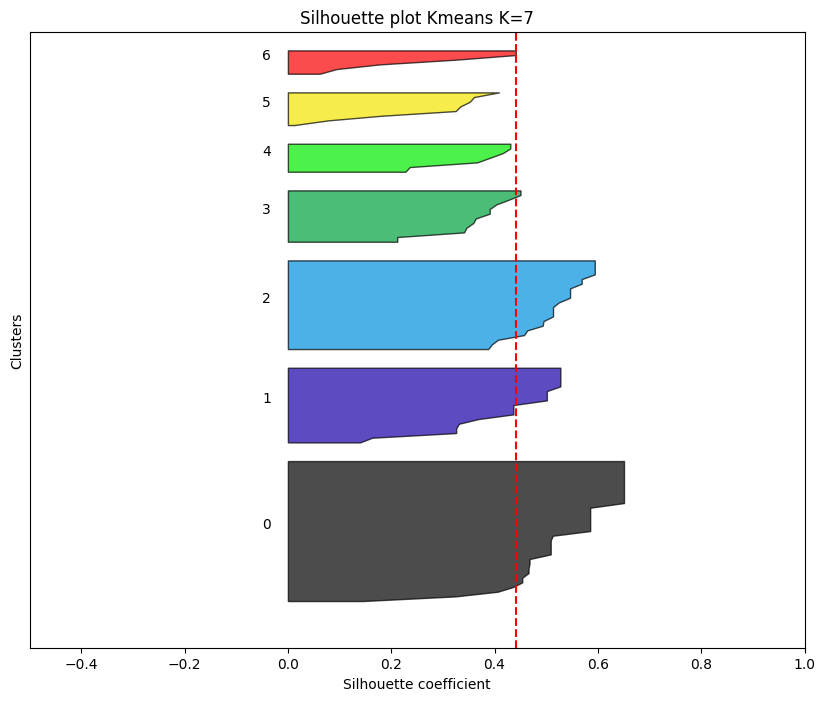

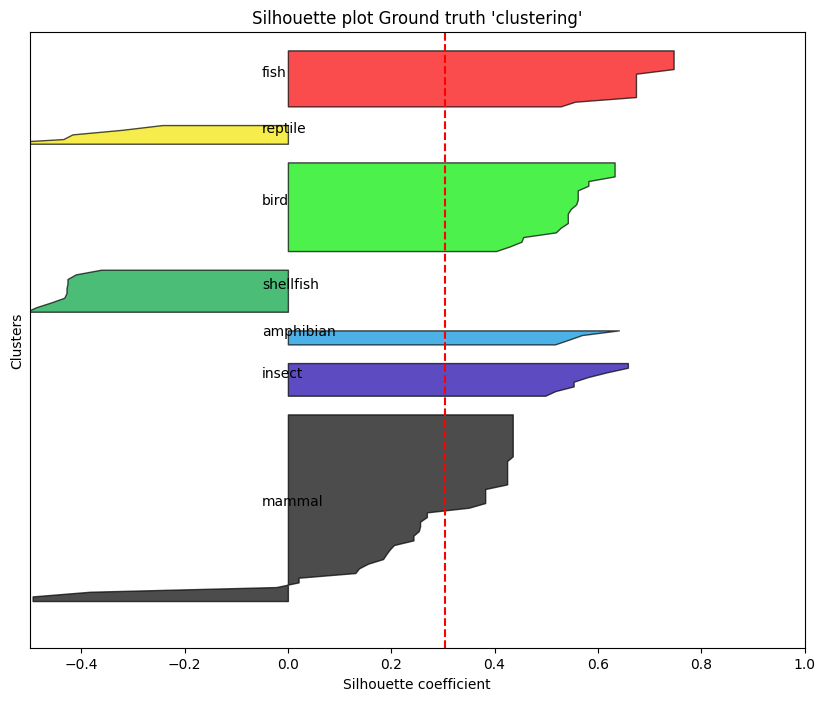

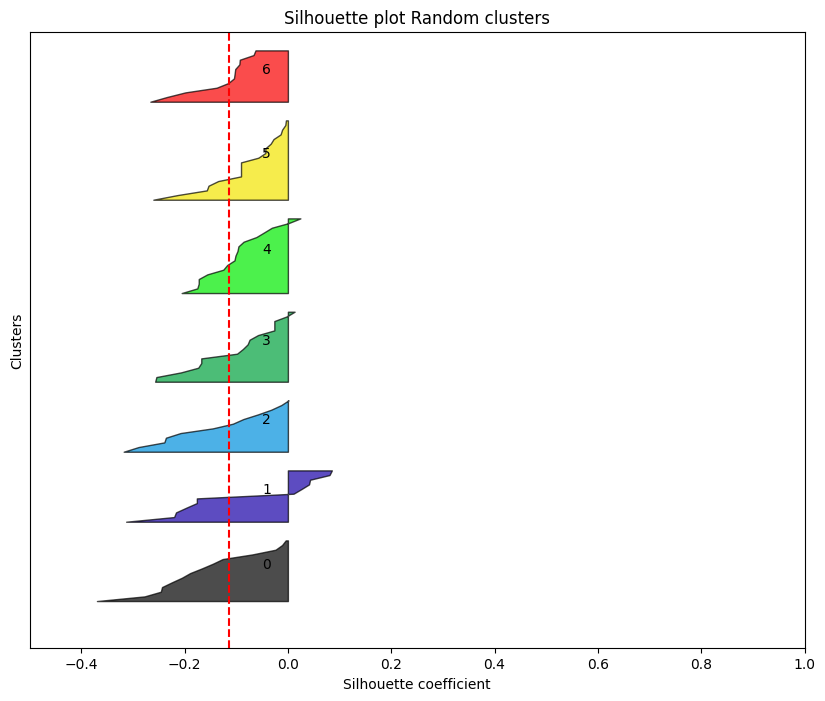

In [69]:
drawSillouette(X, kms_zoo.labels_, "Kmeans K=7")
drawSillouette(X, y, "Ground truth 'clustering'")
drawSillouette(X, rand_clust, "Random clusters")

**Exercises**
1. Discuss these results
2. Can you identify outliers?  How would you go about that?
2. Identify the best cluster modeling approach for discriminating animals according to their characteristics. 

